<center>
        <h1>
                Gaussian Frosting: <br>
                Editable Complex Radiance Fields with Real-Time Rendering
        </h1>
        <h2>
                Master 2 MVA - 2025-2026
        </h2>
        <font size="5">
                GDA PROJECT<br>
        </font>
        Adapted from the original paper by
        Antoine Guédon and Vincent Lepetit
</center>

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import glob
from frosting_scene.gs_model import GaussianSplattingWrapper
from frosting_scene.frosting_model import load_frosting_model

torch.cuda.set_device('cuda:0')
device = torch.device(torch.cuda.current_device())

Using original 3DGS rasterizer from Inria.
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Using original 3DGS rasterizer from Inria.


/mnt/homeGPU/aruiz/frosting/lib/python3.9/site-packages/torch/utils/cpp_extension.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging  # type: ignore[attr-defined]


In [2]:
# Path to your COLMAP dataset. You can change the path to the dataset you want to use.
source_path= './own_data/stick/'
if source_path[-1] != '/':
    source_path += '/'
your_scene_name = source_path.split('/')[-2]

# Path to the vanilla 3DGS output directory. You can change the path to the directory you want to use.
gs_output_dir = f'./output/vanilla_gs/{your_scene_name}/'

# Path to the Frosting model. You can change the path to the model you want to use.
frosting_dir = f'./output/refined_frosting/{your_scene_name}'
frosting_path = os.path.join(frosting_dir, os.listdir(frosting_dir)[0], '15000.pt')

print("Path to the COLMAP dataset: ", source_path, sep='\n')
print("Path to the vanilla 3DGS output directory: ", gs_output_dir, sep='\n')
print("Path to the Frosting model: ", frosting_path, sep='\n')

Path to the COLMAP dataset: 
./own_data/stick/
Path to the vanilla 3DGS output directory: 
./output/vanilla_gs/stick/
Path to the Frosting model: 
./output/refined_frosting/stick/frostingfine_3Dgs7000_densityestim02_sdfnorm02_level03_decim1000000_depthauto_quantile01_gauss2000000_frostlevel001_proposal30/15000.pt


## Load corresponding Vanilla 3DGS Model

In [3]:
eval_split = True
load_gt_images = True
white_background = False
bg_color = [1., 1., 1.] if white_background else [0., 0., 0.]

gs_model = GaussianSplattingWrapper(
    source_path=source_path,
    output_path=gs_output_dir if gs_output_dir.endswith(os.sep) else gs_output_dir + os.sep,
    iteration_to_load=7000,
    load_gt_images=load_gt_images,
    eval_split=eval_split,
    eval_split_interval=8,
    background=bg_color,
    white_background=white_background,
    remove_camera_indices=[],
)

Found image extension .jpg


Rendering image for camera index: 70


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.044212885..1.015942].


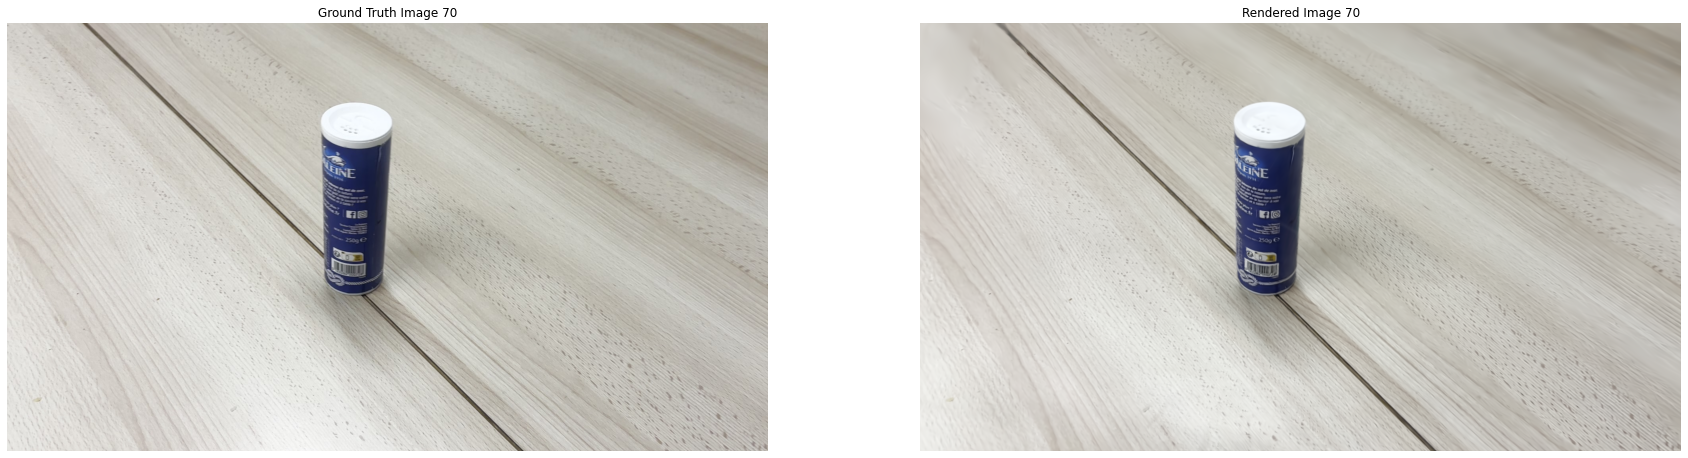

In [4]:
cam_idx = np.random.randint(0, len(gs_model.training_cameras))

print(f'Rendering image for camera index: {cam_idx}')
with torch.no_grad():
    # Render image with the Gaussian Splatting model
    rgb_img = gs_model.render_image(camera_indices=cam_idx).cpu()
    
    # Get GT image if available
    if load_gt_images:
        gt_img = gs_model.get_gt_image(cam_idx).cpu()
    else:
        gt_img = torch.zeros_like(rgb_img)

figsize = 30
height, width = rgb_img.shape[0], rgb_img.shape[1]
plt.figure(figsize=(figsize, figsize * height / width / 2))

plt.subplot(1, 2, 1)
plt.imshow(gt_img)
plt.title(f'Ground Truth Image {cam_idx}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rgb_img)
plt.title(f'Rendered Image {cam_idx}')
plt.axis('off')

plt.show()

## Load Frosting model

In [5]:
frosting = load_frosting_model(frosting_path, nerfmodel=gs_model)

print(f"Number of vertices in base mesh: {len(frosting._shell_base_verts)}")
print(f"Number of faces in base mesh: {len(frosting._shell_base_faces)}")
print(f"Number of Gaussians in the frosting layer: {len(frosting._bary_coords)}")
if frosting.use_background_gaussians:
    print(f"Number of Gaussians in the background: {len(frosting._bg_points)}")

Creating Frosting model from checkpoint: ./output/refined_frosting/stick/frostingfine_3Dgs7000_densityestim02_sdfnorm02_level03_decim1000000_depthauto_quantile01_gauss2000000_frostlevel001_proposal30/15000.pt
No coarse sugar model provided. The frosting will not be initialized.

 [GDA ADAPTIVE ANALYSIS - ROBUST]
 = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
 > Scene Scale (Diag):    17.7409
 > Relative Mean:         0.000351
 > Relative Std:          0.000000
 > Fuzziness Score:       0.000351 (Mean + Std)

GDA PROJECT - Initialization Strategy:
   > Force Exact Budget: False
   > Target Budget: 2000000
   > Ratio Uniform: 0.5
   > Mode: LEGACY (Guarantees coverage, may increase budget)
   > Legacy n_min per cell: 2
   > Final Actual Gaussian Count: 2000000
Frosting loaded.
Number of vertices in base mesh: 438825
Number of faces in base mesh: 863715
Number of Gaussians in the frosting layer: 2000000
Number of Gaussians in the background: 870


## Render

In [6]:
# If your model was trained with occlusion culling, set use_occlusion_culling to True.
# Otherwise, set it to False.

# use_occlusion_culling = True
use_occlusion_culling = False

Index: 142
Frosting Camera Name: 0164
GS Model Camera Name: 0164
Sincronización correcta.
Rendering image 142...


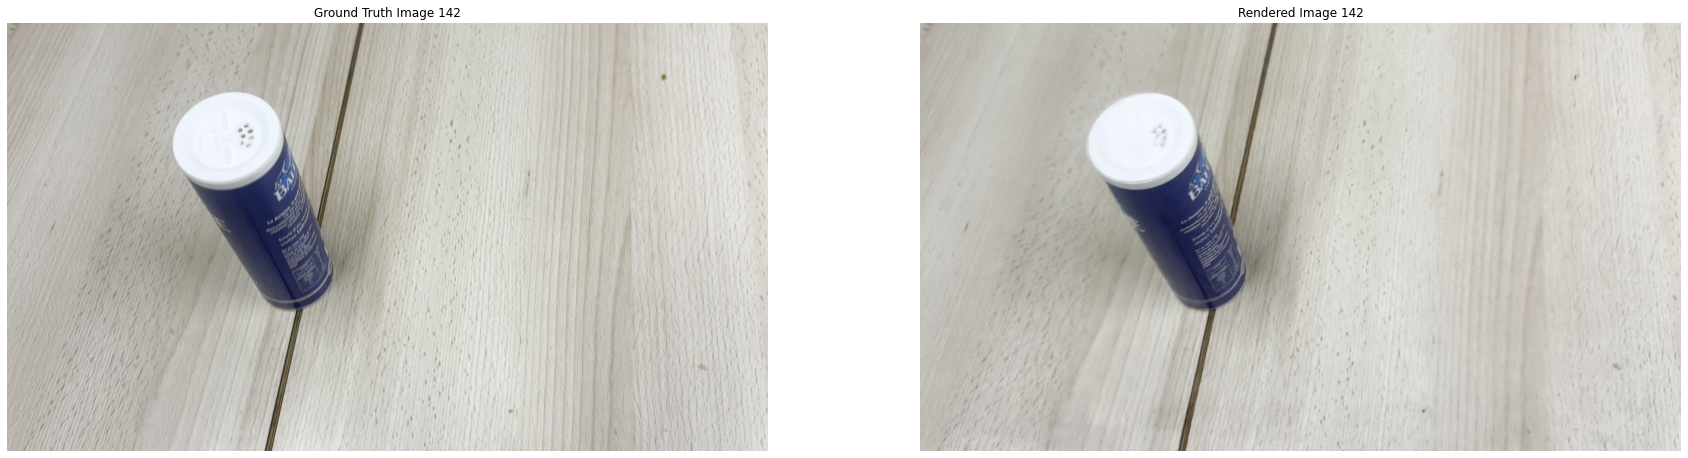

In [7]:
cam_idx = np.random.randint(0, len(gs_model.training_cameras))

frosting_cam_info = frosting.nerfmodel.training_cameras.gs_cameras[cam_idx]
gs_cam_info = gs_model.training_cameras.gs_cameras[cam_idx]

print(f"Index: {cam_idx}")
print(f"Frosting Camera Name: {frosting_cam_info.image_name}")
print(f"GS Model Camera Name: {gs_cam_info.image_name}")

if frosting_cam_info.image_name != gs_cam_info.image_name:
    print("¡ALERTA! Hay una desincronización entre los modelos. Vuelve a ejecutar la celda 'Load Frosting model'.")
else:
    print("Sincronización correcta.")

print(f"Rendering image {cam_idx}...")
with torch.no_grad():
    # Render RGB image
    rgb_img = frosting.render_image_gaussian_rasterizer(
        camera_indices=cam_idx,
        compute_color_in_rasterizer=True,
        use_occlusion_culling=use_occlusion_culling,
        bg_color=torch.tensor(bg_color, device=device),
    ).clamp(0, 1)
    
    # Get GT image for comparison
    if load_gt_images:
        gt_img = gs_model.get_gt_image(cam_idx).cpu()
    else:
        gt_img = torch.zeros_like(rgb_img)
    
figsize = 30
height, width = rgb_img.shape[0], rgb_img.shape[1]
n_rows, n_cols = 1, 2
if height > width:
    figsize = figsize * width / height
plt.figure(figsize=(figsize, figsize * height / width / n_cols * n_rows))

plt.subplot(n_rows, n_cols, 1)
plt.imshow(gt_img.cpu())
plt.title(f'Ground Truth Image {cam_idx}')
plt.axis('off')

plt.subplot(n_rows, n_cols, 2)
plt.imshow(rgb_img.cpu())
plt.title(f'Rendered Image {cam_idx}')
plt.axis('off')

plt.show()

## Ratio in Frosting initialization (Visual Comparison)

<mark><b>Requires:</b></mark> `gs_model` (the vanilla 3DGS model)

### Original - Frosting Comparison

> Processing Ratio 0.0...
Creating Frosting model from checkpoint: output/refined_frosting/khady/frostingfine_unifSampRatio00_3Dgs7000_densityestim02_sdfnorm02_level03_decim1000000_depthauto_quantile00_gauss100000_frostlevel001_proposal30/15000.pt
No coarse sugar model provided. The frosting will not be initialized.

GDA PROJECT - Frosting initialization:
Experimental ratio of uniform sampling: 0.5.
Using n_min_gaussian_per_cell=1 (based on ratio).
Frosting loaded.
> Processing Ratio 0.25...
Creating Frosting model from checkpoint: output/refined_frosting/khady/frostingfine_unifSampRatio025_3Dgs7000_densityestim02_sdfnorm02_level03_decim1000000_depthauto_quantile00_gauss100000_frostlevel001_proposal30/15000.pt


KeyboardInterrupt: 

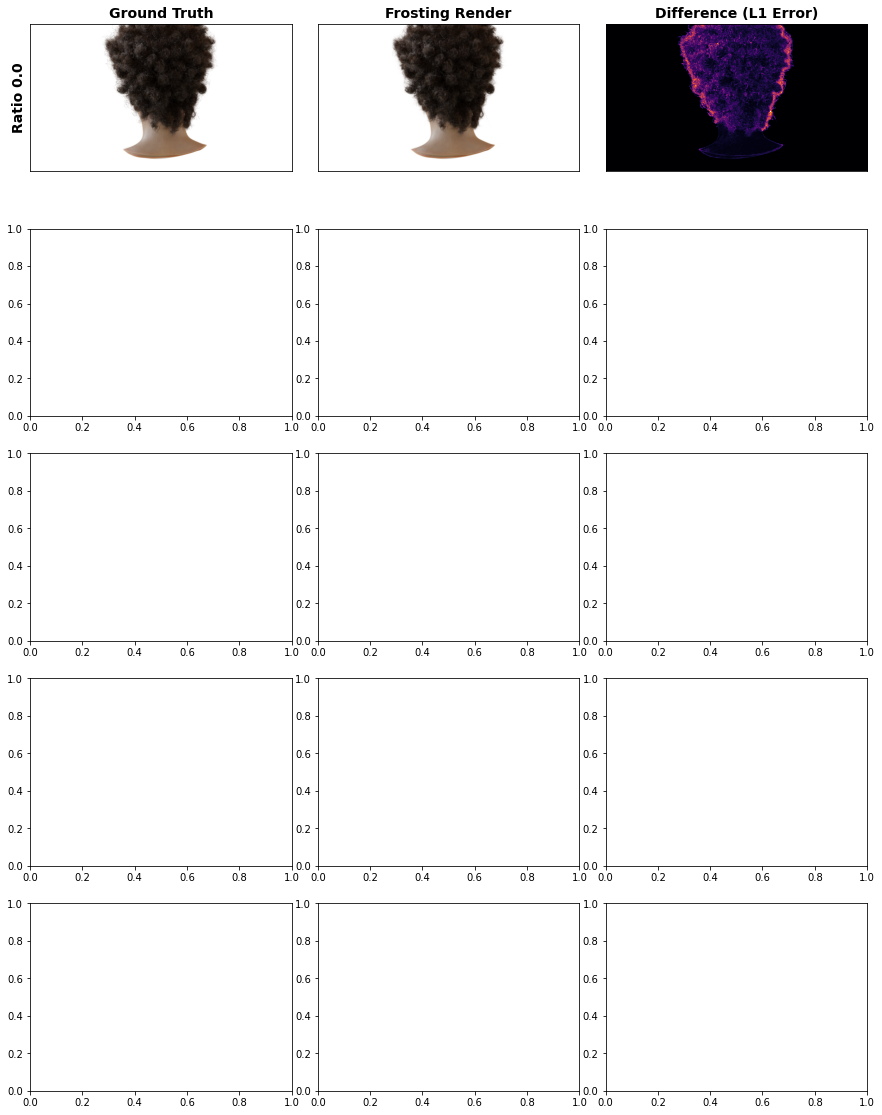

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import glob

MODELS_ROOT = "output/refined_frosting/khady/" 
RATIOS = [0.0, 0.25, 0.5, 0.75, 1.0]
# CAM_IDX = 29    # Test
CAM_IDX = 54    # Train

CMAP_ERROR = 'inferno'
ERROR_VMAX = 0.2

N_GAUSSIANS = 1_000_00

# GENERATING PLOT
n_rows = len(RATIOS)
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

with torch.no_grad():
    gt_tensor = gs_model.get_gt_image(camera_indices=CAM_IDX)
    gt_np = gt_tensor.cpu().numpy()

# Check shape consistency (H, W, C)
if gt_np.shape[0] == 3: gt_np = gt_np.transpose(1, 2, 0) # Convert (3,H,W) -> (H,W,3)

for i, ratio in enumerate(RATIOS):
    print(f"> Processing Ratio {ratio}...")
    
    # 2. Find the model path automatically
    # Pattern: *unifSampRatio{ratio_str}*
    ratio_str = str(ratio).replace('.', '')
    if len(ratio_str) == 1: ratio_str += '0' # Fix 0.0 -> 00
    
    search_pattern = os.path.join(MODELS_ROOT, f"*unifSampRatio{ratio_str}_*_gauss{N_GAUSSIANS}_*")
    candidates = glob.glob(search_pattern)
    
    if not candidates:
        print(f"   [Warning] Model for ratio {ratio} not found. Skipping row.")
        continue
        
    model_path = os.path.join(candidates[0], "15000.pt")
    
    try:
        # 3. Load Frosting Model
        # We reuse 'gs_model' to initialize, which is faster
        frosting_ratio = load_frosting_model(model_path, nerfmodel=gs_model, device=device)
        frosting_ratio.eval()
        
        # 4. Render
        with torch.no_grad():
            render_pkg = frosting_ratio.render_image_gaussian_rasterizer(
                camera_indices=CAM_IDX,
                bg_color=torch.tensor(bg_color, device=device),
                compute_color_in_rasterizer=True,
                use_occlusion_culling=False
            ).clamp(0, 1)
            
        render_np = render_pkg.cpu().numpy()
        
        # 5. Compute Difference (Heatmap)
        # Mean across RGB channels to get intensity of error
        diff_map = np.abs(gt_np - render_np).mean(axis=2)

        # 6. Plot Row
        # Column 1: Ground Truth
        ax_gt = axes[i, 0]
        ax_gt.imshow(gt_np)
        ax_gt.set_ylabel(f"Ratio {ratio}", fontsize=14, fontweight='bold')
        if i == 0: ax_gt.set_title("Ground Truth", fontsize=14, fontweight='bold')
        ax_gt.set_xticks([])
        ax_gt.set_yticks([])
        
        # Column 2: Frosting Render
        ax_ren = axes[i, 1]
        ax_ren.imshow(render_np)
        if i == 0: ax_ren.set_title("Frosting Render", fontsize=14, fontweight='bold')
        ax_ren.set_xticks([])
        ax_ren.set_yticks([])
        
        # Column 3: Difference Heatmap
        ax_dif = axes[i, 2]
        im = ax_dif.imshow(diff_map, cmap=CMAP_ERROR, vmin=0, vmax=ERROR_VMAX) 
        if i == 0: ax_dif.set_title("Difference (L1 Error)", fontsize=14, fontweight='bold')
        ax_dif.set_xticks([])
        ax_dif.set_yticks([])
        
        # Add colorbar only to the last plot to save space
        if i == len(RATIOS) - 1:
            cbar = fig.colorbar(im, ax=ax_dif, orientation='horizontal', fraction=0.05, pad=0.05)
            cbar.set_label('Error Magnitude', fontsize=10)

        # Cleanup memory
        del frosting_ratio
        torch.cuda.empty_cache()
        
    except Exception as e:
        print(f"[Error] Failed processing ratio {ratio}: {e}")

plt.show()

### Using PIL

Generating Visual Difference (PIL) for Camera 22...
Creating Frosting model from checkpoint: output/refined_frosting/khady/frostingfine_unifSampRatio00_3Dgs7000_densityestim02_sdfnorm02_level03_decim1000000_depthauto_quantile00_gauss1000000_frostlevel001_proposal30/15000.pt
No coarse sugar model provided. The frosting will not be initialized.

GDA PROJECT - Frosting initialization:
Experimental ratio of uniform sampling: 0.5.
Using n_min_gaussian_per_cell=6 (based on ratio).
Frosting loaded.
Creating Frosting model from checkpoint: output/refined_frosting/khady/frostingfine_unifSampRatio025_3Dgs7000_densityestim02_sdfnorm02_level03_decim1000000_depthauto_quantile00_gauss1000000_frostlevel001_proposal30/15000.pt
No coarse sugar model provided. The frosting will not be initialized.

GDA PROJECT - Frosting initialization:
Experimental ratio of uniform sampling: 0.5.
Using n_min_gaussian_per_cell=6 (based on ratio).
Frosting loaded.
Creating Frosting model from checkpoint: output/refined_f

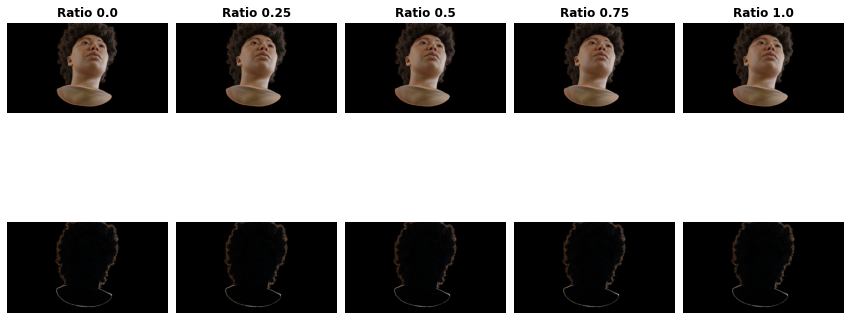

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import glob
from PIL import Image, ImageChops
from frosting_scene.frosting_model import load_frosting_model

# ==========================================
# CONFIGURATION
# ==========================================
MODELS_ROOT = "output/refined_frosting/khady/" 
RATIOS = [0.0, 0.25, 0.5, 0.75, 1.0]
CAM_IDX = 22
INVERT_DIFF = False # Set to True to get White background (better for papers)

# ==========================================
# HELPER: TENSOR TO PIL
# ==========================================
def tensor_to_pil(tensor):
    """Converts a GPU Tensor (C, H, W) [0,1] to a PIL Image (H, W, C) [0,255]"""
    arr = tensor.clamp(0, 1).cpu().numpy()
    arr = (arr * 255).astype(np.uint8)
    return Image.fromarray(arr)

# ==========================================
# VISUALIZATION LOOP
# ==========================================
n_rows = 2 # Row 1: Render, Row 2: Difference
fig, axes = plt.subplots(n_rows, len(RATIOS), figsize=(3 * len(RATIOS), 7))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

print(f"Generating Visual Difference (PIL) for Camera {CAM_IDX}...")

# 1. Load GT (Once)
with torch.no_grad():
    gt_tensor = gs_model.get_gt_image(camera_indices=CAM_IDX)
    gt_pil = tensor_to_pil(gt_tensor)

for i, ratio in enumerate(RATIOS):
    # Find Model
    ratio_str = str(ratio).replace('.', '')
    if len(ratio_str) == 1: ratio_str += '0'
    
    pattern = os.path.join(MODELS_ROOT, f"*unifSampRatio{ratio_str}_*")
    candidates = glob.glob(pattern)
    
    if not candidates:
        print(f"   [Skip] Ratio {ratio} not found.")
        continue
        
    ckpt = os.path.join(candidates[0], "15000.pt")
    
    try:
        # Load
        frosting = load_frosting_model(ckpt, nerfmodel=gs_model, device=device, uniform_sampling_ratio=ratio)
        frosting.eval()
        
        # Render
        with torch.no_grad():
            render_pkg = frosting.render_image_gaussian_rasterizer(
                camera_indices=CAM_IDX,
                bg_color=torch.tensor(bg_color, device=device),
                compute_color_in_rasterizer=True,
                use_occlusion_culling=False
            ).clamp(0, 1)
            
        # Convert to PIL
        render_pil = tensor_to_pil(render_pkg)
        
        # --- MAGIC HAPPENS HERE: PIL DIFFERENCE ---
        # 1. Calculate absolute difference
        diff_img = ImageChops.difference(gt_pil, render_pil)
        
        # 2. (Optional) Invert for better visibility in papers
        # If Inverted: White = Perfect, Dark/Color = Error
        if INVERT_DIFF:
            diff_img = ImageChops.invert(diff_img)
        
        # Plotting
        
        # Row 1: Render
        ax_ren = axes[0, i]
        ax_ren.imshow(render_pil)
        ax_ren.set_title(f"Ratio {ratio}", fontsize=12, fontweight='bold')
        if i==0: ax_ren.set_ylabel("Frosting Render", fontsize=12, fontweight='bold')
        ax_ren.axis('off')
        
        # Row 2: Difference
        ax_dif = axes[1, i]
        ax_dif.imshow(diff_img)
        if i==0: 
            label = "Difference (Inverted)" if INVERT_DIFF else "Difference (Black BG)"
            ax_dif.set_ylabel(label, fontsize=12, fontweight='bold')
        ax_dif.axis('off')

        del frosting
        torch.cuda.empty_cache()

    except Exception as e:
        print(f"Error {ratio}: {e}")

plt.show()

Generating Visual Difference (PIL) for Camera 22...
GT Tensor Shape: torch.Size([1080, 1920, 3])
Creating Frosting model from checkpoint: output/refined_frosting/khady/frostingfine_unifSampRatio00_3Dgs7000_densityestim02_sdfnorm02_level03_decim1000000_depthauto_quantile00_gauss1000000_frostlevel001_proposal30/15000.pt
No coarse sugar model provided. The frosting will not be initialized.

GDA PROJECT - Frosting initialization:
Experimental ratio of uniform sampling: 0.5.
Using n_min_gaussian_per_cell=6 (based on ratio).
Frosting loaded.
Creating Frosting model from checkpoint: output/refined_frosting/khady/frostingfine_unifSampRatio025_3Dgs7000_densityestim02_sdfnorm02_level03_decim1000000_depthauto_quantile00_gauss1000000_frostlevel001_proposal30/15000.pt
No coarse sugar model provided. The frosting will not be initialized.

GDA PROJECT - Frosting initialization:
Experimental ratio of uniform sampling: 0.5.
Using n_min_gaussian_per_cell=6 (based on ratio).
Frosting loaded.
Creating Fro

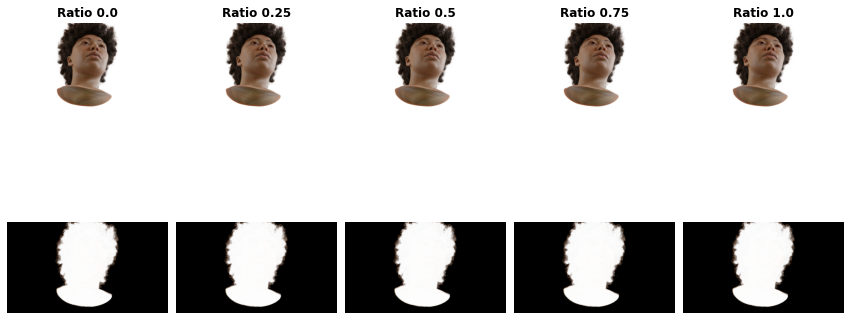

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import glob
from PIL import Image, ImageChops
from frosting_scene.frosting_model import load_frosting_model

# ==========================================
# CONFIGURATION
# ==========================================
MODELS_ROOT = "output/refined_frosting/khady/" 
RATIOS = [0.0, 0.25, 0.5, 0.75, 1.0]
CAM_IDX = 22
INVERT_DIFF = True 

# ==========================================
# HELPER: TENSOR TO PIL (ROBUSTO)
# ==========================================
def tensor_to_pil(tensor):
    """
    Convierte un Tensor GPU a imagen PIL de forma segura,
    detectando automáticamente el orden de los canales.
    """
    # 1. Detach y CPU
    t = tensor.detach().cpu()
    
    # 2. Si tiene dimensión de batch (ej: 1, 3, H, W), la quitamos
    if t.dim() == 4:
        t = t.squeeze(0)
    
    # 3. Comprobar si necesita permutar (C, H, W) -> (H, W, C)
    # Heurística: Si la dim 0 es pequeña (1, 3 o 4), es C, H, W.
    if t.shape[0] in [1, 3, 4]:
        t = t.permute(1, 2, 0)
    
    # 4. Convertir a Numpy y escalar
    arr = t.numpy()
    arr = np.clip(arr * 255.0, 0, 255).astype(np.uint8)
    
    # 5. Manejar escala de grises si es (H, W, 1)
    if arr.ndim == 3 and arr.shape[2] == 1:
        arr = arr.squeeze(2)
        
    return Image.fromarray(arr)

# ==========================================
# VISUALIZATION LOOP
# ==========================================
n_rows = 2 
fig, axes = plt.subplots(n_rows, len(RATIOS), figsize=(3 * len(RATIOS), 7))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

print(f"Generating Visual Difference (PIL) for Camera {CAM_IDX}...")

# 1. Load GT (Once)
with torch.no_grad():
    gt_tensor = gs_model.get_gt_image(camera_indices=CAM_IDX)
    # Debug: Imprimir forma para asegurar que es correcta
    print(f"GT Tensor Shape: {gt_tensor.shape}") 
    gt_pil = tensor_to_pil(gt_tensor)

for i, ratio in enumerate(RATIOS):
    # Find Model
    ratio_str = str(ratio).replace('.', '')
    if len(ratio_str) == 1: ratio_str += '0'
    
    pattern = os.path.join(MODELS_ROOT, f"*unifSampRatio{ratio_str}_*")
    candidates = glob.glob(pattern)
    
    if not candidates:
        print(f"   [Skip] Ratio {ratio} not found.")
        continue
        
    ckpt = os.path.join(candidates[0], "15000.pt")
    
    try:
        # Load
        frosting = load_frosting_model(ckpt, nerfmodel=gs_model, device=device, uniform_sampling_ratio=ratio)
        frosting.eval()
        
        # Render
        with torch.no_grad():
            render_pkg = frosting.render_image_gaussian_rasterizer(
                nerf_cameras=gs_model.training_cameras,
                camera_indices=CAM_IDX,
                bg_color=torch.tensor([1., 1., 1.], device=device),
                compute_color_in_rasterizer=True,
                use_occlusion_culling=False
            )
            
        # Convert to PIL
        render_pil = tensor_to_pil(render_pkg)
        
        # --- PIL DIFFERENCE ---
        diff_img = ImageChops.difference(gt_pil, render_pil)
        
        if INVERT_DIFF:
            diff_img = ImageChops.invert(diff_img)
        
        # Plotting
        # Row 1: Render
        ax_ren = axes[0, i]
        ax_ren.imshow(render_pil)
        ax_ren.set_title(f"Ratio {ratio}", fontsize=12, fontweight='bold')
        if i==0: ax_ren.set_ylabel("Frosting Render", fontsize=12, fontweight='bold')
        ax_ren.axis('off')
        
        # Row 2: Difference
        ax_dif = axes[1, i]
        ax_dif.imshow(diff_img)
        if i==0: 
            label = "Diff (Inverted)" if INVERT_DIFF else "Diff (Black BG)"
            ax_dif.set_ylabel(label, fontsize=12, fontweight='bold')
        ax_dif.axis('off')

        del frosting
        torch.cuda.empty_cache()

    except Exception as e:
        print(f"Error {ratio}: {e}")

plt.show()

### Frosting 0.5 (as base) - Frosting ratio Comparison

In [14]:
from frosting_scene.frosting_model import load_frosting_model
MODELS_ROOT = "output/refined_frosting/khady/" 
RATIOS = [0.0, 0.25, 0.5, 0.75, 1.0]
CAM_IDX = 29    # 29 in Test, 54 in Train
N_GAUSSIANS = 10000
CHECKPOINT = "15000.pt"
FORCE_EXACT_GAUSSIANS_NUMBER = True

# Dictionary to store results in RAM (CPU)
# Structure: {ratio: {'render': numpy_array, 'diff': numpy_array}}
experiment_data = {} 
gt_image_np = None

print(f"Starting Batch Rendering for Camera {CAM_IDX}...")

# Get Ground Truth (Once)
with torch.no_grad():
    gt_tensor = gs_model.get_gt_image(camera_indices=CAM_IDX)
    gt_image_np = gt_tensor.cpu().numpy()

# Fix GT Shape (C, H, W) -> (H, W, C)
if gt_image_np.shape[0] == 3: 
    gt_image_np = gt_image_np.transpose(1, 2, 0)

print("> GT Image Loaded.")

# Loop through Ratios
for ratio in RATIOS:
    print(f"> Processing Ratio {ratio}...")
    
    # Pattern matching
    ratio_str = str(ratio).replace('.', '')
    if len(ratio_str) == 1: ratio_str += '0'
    
    search_pattern = os.path.join(MODELS_ROOT, f"*unifSampRatio{ratio_str}_*_gauss{N_GAUSSIANS}_*")
    candidates = glob.glob(search_pattern)
    
    if not candidates:
        print(f"   [Warning] Model for ratio {ratio} not found. Skipping.")
        continue
        
    model_path = os.path.join(candidates[0], CHECKPOINT)
    
    try:
        # Load Model
        frosting_ratio = load_frosting_model(
            model_path, 
            nerfmodel=gs_model, 
            device=device, 
            uniform_sampling_ratio=ratio,
            force_exact_gaussians_number=FORCE_EXACT_GAUSSIANS_NUMBER
        )
        frosting_ratio.eval()
        
        # Render
        with torch.no_grad():
            render_pkg = frosting_ratio.render_image_gaussian_rasterizer(
                camera_indices=CAM_IDX,
                bg_color=torch.tensor(bg_color, device=device),
                compute_color_in_rasterizer=True,
                use_occlusion_culling=False
            ).clamp(0, 1)
            
        render_np = render_pkg.cpu().numpy()
        
        # Shape correction for render if needed
        if render_np.shape[0] == 3:
            render_np = render_np.transpose(1, 2, 0)
            
        # Compute Difference (L1 Mean) - Ready for heatmap
        diff_map = np.abs(gt_image_np - render_np).mean(axis=2)
        
        # Store in Dictionary (Optimized RAM usage)
        experiment_data[ratio] = {
            'render': render_np,
            'diff': diff_map
        }

        # Cleanup GPU
        del frosting_ratio
        torch.cuda.empty_cache()
        
    except Exception as e:
        print(f"   [Error] Failed ratio {ratio}: {e}")

print("Batch Processing Complete. Images stored in 'experiment_data'.")

Starting Batch Rendering for Camera 29...
> GT Image Loaded.
> Processing Ratio 0.0...
Creating Frosting model from checkpoint: output/refined_frosting/khady/frostingfine_unifSampRatio00_3Dgs7000_densityestim02_sdfnorm02_level03_decim1000000_depthauto_quantile00_gauss10000_frostlevel001_proposal30/15000.pt
No coarse sugar model provided. The frosting will not be initialized.
GDA PROJECT - Initialization Strategy:
   > Force Exact Budget: True
   > Target Budget: 10000
   > Ratio Uniform: 0.0
   > Mode: STRICT (Allowing empty cells to respect budget)
   > Final Actual Gaussian Count: 10000
Frosting loaded.
> Processing Ratio 0.25...
Creating Frosting model from checkpoint: output/refined_frosting/khady/frostingfine_unifSampRatio025_3Dgs7000_densityestim02_sdfnorm02_level03_decim1000000_depthauto_quantile00_gauss10000_frostlevel001_proposal30/15000.pt
No coarse sugar model provided. The frosting will not be initialized.
GDA PROJECT - Initialization Strategy:
   > Force Exact Budget: True

#### Frosting ratios vs Ground Truth

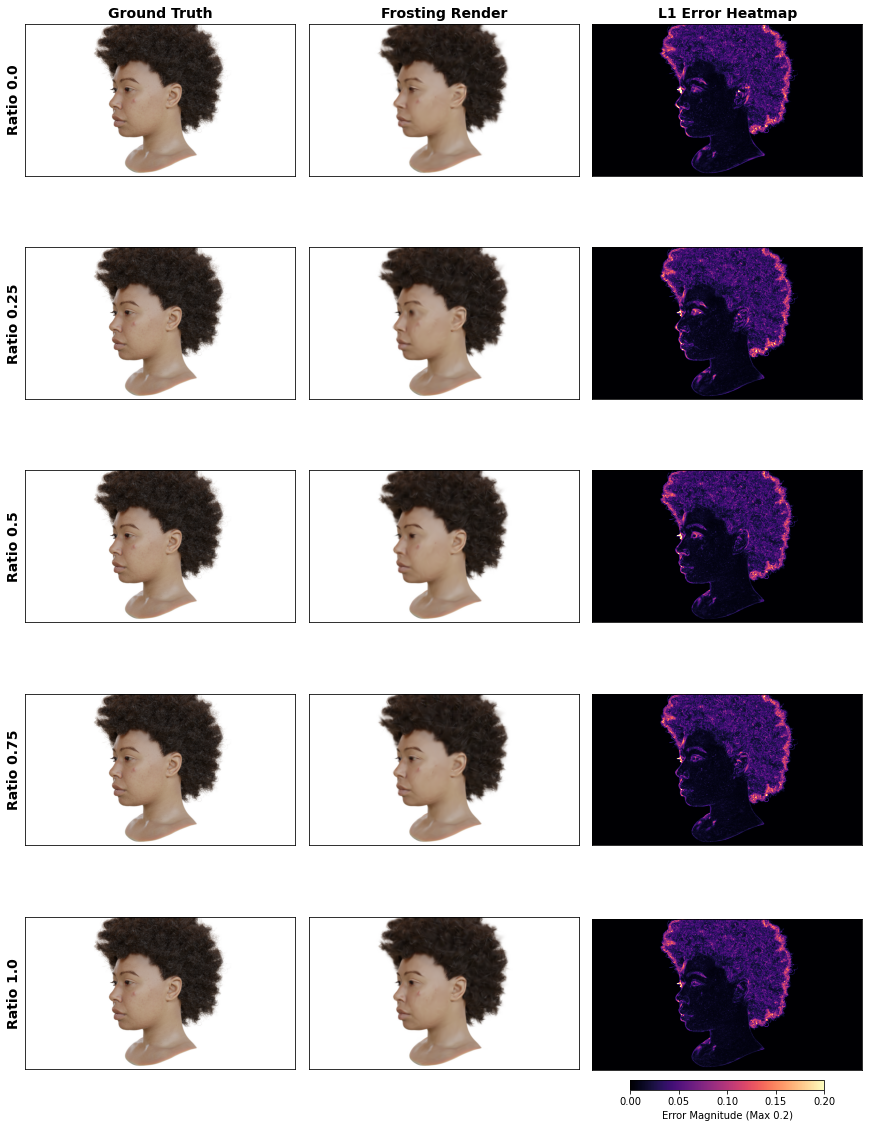

In [15]:
CMAP_ERROR = 'magma' # 'magma', 'turbo', 'viridis', 'inferno'
ERROR_VMAX = 0.2       # Sensitivity (0.05 for subtle errors, 0.2 for large ones)

# Setup Figure
n_ratios = len(experiment_data)
if n_ratios == 0:
    print("No data to plot!")
else:
    n_rows = n_ratios
    n_cols = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    plt.subplots_adjust(wspace=0.05, hspace=0.15)

    # Sort keys to ensure order (0.0 -> 1.0)
    sorted_ratios = sorted(experiment_data.keys())

    for i, ratio in enumerate(sorted_ratios):
        data = experiment_data[ratio]
        
        # Column 1: Ground Truth (Reference)
        ax_gt = axes[i, 0]
        ax_gt.imshow(gt_image_np)
        ax_gt.set_ylabel(f"Ratio {ratio}", fontsize=14, fontweight='bold')
        if i == 0: ax_gt.set_title("Ground Truth", fontsize=14, fontweight='bold')
        ax_gt.set_xticks([]); ax_gt.set_yticks([])
        
        # Column 2: Frosting Render
        ax_ren = axes[i, 1]
        ax_ren.imshow(data['render'])
        if i == 0: ax_ren.set_title("Frosting Render", fontsize=14, fontweight='bold')
        ax_ren.set_xticks([]); ax_ren.set_yticks([])
        
        # Column 3: Difference Heatmap
        ax_dif = axes[i, 2]
        im = ax_dif.imshow(data['diff'], cmap=CMAP_ERROR, vmin=0, vmax=ERROR_VMAX)
        if i == 0: ax_dif.set_title("L1 Error Heatmap", fontsize=14, fontweight='bold')
        ax_dif.set_xticks([]); ax_dif.set_yticks([])
        
        # Add colorbar to the last row
        if i == len(sorted_ratios) - 1:
            cbar = fig.colorbar(im, ax=ax_dif, orientation='horizontal', fraction=0.05, pad=0.05)
            cbar.set_label(f'Error Magnitude (Max {ERROR_VMAX})', fontsize=10)

    plt.show()

#### Frosting ratios vs Frosting 0.5

Generating Sensitivity Analysis vs Ratio 0.5...


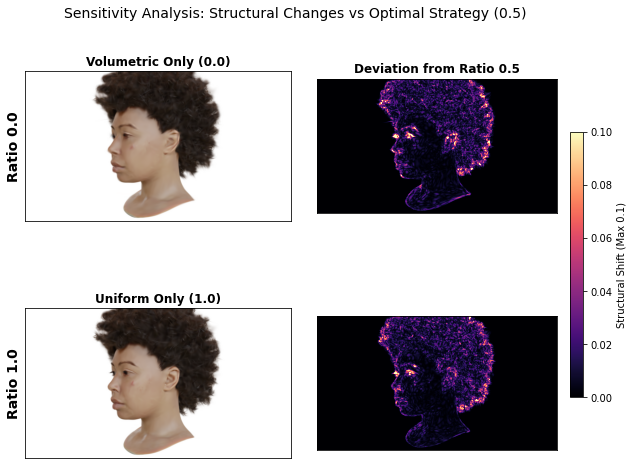

In [16]:
RATIO_BEST = 0.5 # Reference ratio
RATIOS_COMPARE = [0.0, 1.0] # Volumetric vs Uniform

CMAP_DIFF = 'magma'
VMAX_DIFF = 0.1

if 'experiment_data' not in locals() or not experiment_data:
    print("Error: 'experiment_data' is empty. Run the previous batch rendering cell first.")
else:
    # Check if baseline exists
    if RATIO_BEST not in experiment_data:
        print(f"Error: Baseline ratio {RATIO_BEST} not found in experiment_data.")
    else:
        # Get Baseline Render (0.5)
        render_baseline = experiment_data[RATIO_BEST]['render']
        
        # Setup Figure: Rows = Comparisons, Cols = [Render Extreme, Diff vs Baseline]
        n_rows = len(RATIOS_COMPARE)
        n_cols = 2
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        
        print(f"Generating Sensitivity Analysis vs Ratio {RATIO_BEST}...")

        for i, ratio in enumerate(RATIOS_COMPARE):
            if ratio not in experiment_data:
                print(f"   [Warning] Ratio {ratio} missing. Skipping.")
                continue
                
            # Get Extreme Render
            render_extreme = experiment_data[ratio]['render']
            
            # Compute Relative Difference (Structural Change)
            # |Extreme - Baseline|
            diff_relative = np.abs(render_extreme - render_baseline).mean(axis=2)
            
            # Column 1: Render of the Extreme
            ax_ren = axes[i, 0]
            ax_ren.imshow(render_extreme)
            ax_ren.set_ylabel(f"Ratio {ratio}", fontsize=14, fontweight='bold')
            
            # Dynamic Titles
            if ratio == 0.0:
                title = "Volumetric Only (0.0)"
            elif ratio == 1.0:
                title = "Uniform Only (1.0)"
            else:
                title = f"Ratio {ratio}"
            ax_ren.set_title(title, fontsize=12, fontweight='bold')
            ax_ren.set_xticks([]); ax_ren.set_yticks([])
            
            # Column 2: Difference vs Baseline
            ax_dif = axes[i, 1]
            im = ax_dif.imshow(diff_relative, cmap=CMAP_DIFF, vmin=0, vmax=VMAX_DIFF)
            
            # Title explaining what the difference means
            if i == 0: 
                ax_dif.set_title(f"Deviation from Ratio {RATIO_BEST}", fontsize=12, fontweight='bold')
            ax_dif.set_xticks([]); ax_dif.set_yticks([])
            
            # Add colorbar to the last row
            if i == n_rows - 1:
                cbar = fig.colorbar(im, ax=axes[:, 1], orientation='vertical', fraction=0.05, pad=0.05)
                cbar.set_label(f'Structural Shift (Max {VMAX_DIFF})', fontsize=10)

        plt.suptitle(f"Sensitivity Analysis: Structural Changes vs Optimal Strategy ({RATIO_BEST})", fontsize=14, y=0.95)
        plt.show()

#### Gaussian Splatting vs Frosting ratios

Rendering Vanilla 3DGS for Camera 29...
> Vanilla Baseline Ready.


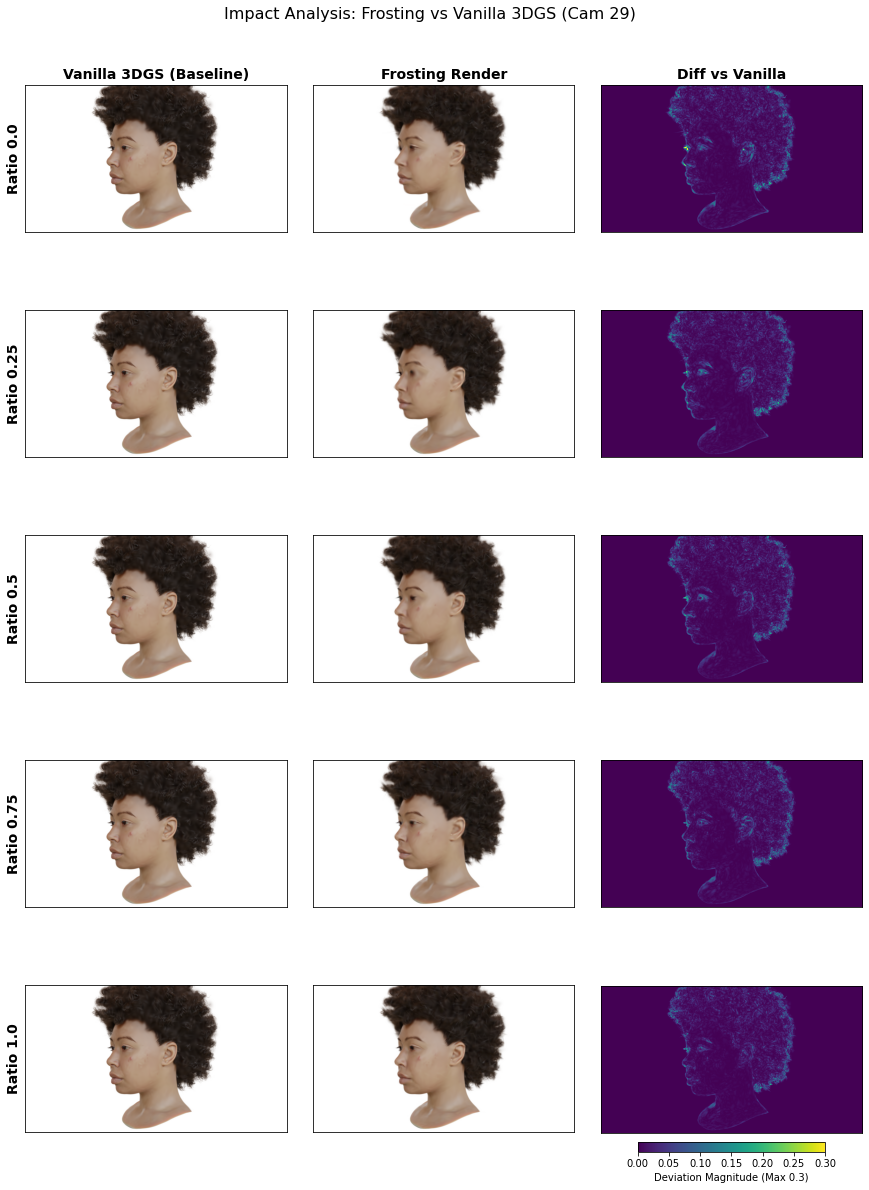

In [17]:
DIFF_CMAP = 'viridis' # 'viridis', 'plasma'
DIFF_VMAX = 0.3

print(f"Rendering Vanilla 3DGS for Camera {CAM_IDX}...")

with torch.no_grad():
    vanilla_tensor = gs_model.render_image(camera_indices=CAM_IDX).clamp(0, 1)
    vanilla_np = vanilla_tensor.cpu().numpy()

if vanilla_np.shape[0] == 3:
    vanilla_np = vanilla_np.transpose(1, 2, 0)

print("> Vanilla Baseline Ready.")

if 'experiment_data' not in locals() or not experiment_data:
    print("[Error] 'experiment_data' dictionary is empty. Please run the 'Batch Processing' cell first.")
else:
    # Prepare Figure
    sorted_ratios = sorted(experiment_data.keys())
    n_rows = len(sorted_ratios)
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4 * n_rows))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    for i, ratio in enumerate(sorted_ratios):
        # Retrieve Pre-calculated Frosting Render
        frosting_render = experiment_data[ratio]['render']
        
        # Compute Difference: |Vanilla - Frosting|
        # This highlights where Frosting modifies the original 3DGS geometry/appearance
        diff_map = np.abs(vanilla_np - frosting_render).mean(axis=2)
        
        # Col 1: Vanilla 3DGS (Reference)
        ax_ref = axes[i, 0]
        ax_ref.imshow(vanilla_np)
        ax_ref.set_ylabel(f"Ratio {ratio}", fontsize=14, fontweight='bold')
        if i == 0: ax_ref.set_title("Vanilla 3DGS (Baseline)", fontsize=14, fontweight='bold')
        ax_ref.set_xticks([]); ax_ref.set_yticks([])
        
        # Col 2: Frosting Render
        ax_ren = axes[i, 1]
        ax_ren.imshow(frosting_render)
        if i == 0: ax_ren.set_title("Frosting Render", fontsize=14, fontweight='bold')
        ax_ren.set_xticks([]); ax_ren.set_yticks([])
        
        # Col 3: Difference Heatmap
        ax_dif = axes[i, 2]
        im = ax_dif.imshow(diff_map, cmap=DIFF_CMAP, vmin=0, vmax=DIFF_VMAX)
        if i == 0: ax_dif.set_title("Diff vs Vanilla", fontsize=14, fontweight='bold')
        ax_dif.set_xticks([]); ax_dif.set_yticks([])
        
        # Colorbar (Bottom)
        if i == n_rows - 1:
            cbar = fig.colorbar(im, ax=ax_dif, orientation='horizontal', fraction=0.05, pad=0.05)
            cbar.set_label(f'Deviation Magnitude (Max {DIFF_VMAX})', fontsize=10)

    plt.suptitle(f"Impact Analysis: Frosting vs Vanilla 3DGS (Cam {CAM_IDX})", fontsize=16, y=0.92)
    plt.show()

Rendering Vanilla 3DGS for Camera 29...
> Vanilla Baseline Ready.


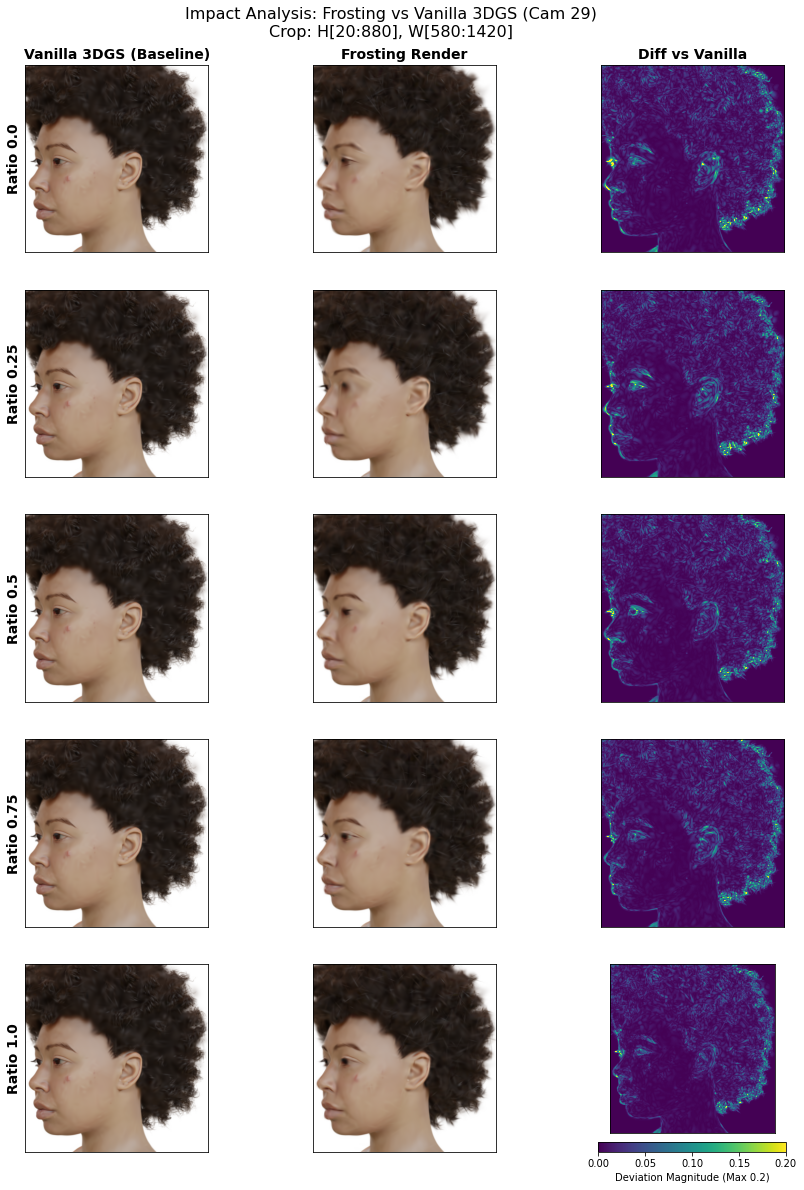

In [18]:
DIFF_CMAP = 'viridis' # 'viridis', 'plasma'
DIFF_VMAX = 0.2

# CROP SETTINGS
H_MIN, H_MAX = 20, 880   # (Y)
W_MIN, W_MAX = 580, 1420  # (X)

print(f"Rendering Vanilla 3DGS for Camera {CAM_IDX}...")

with torch.no_grad():
    vanilla_tensor = gs_model.render_image(camera_indices=CAM_IDX).clamp(0, 1)
    vanilla_np = vanilla_tensor.cpu().numpy()

if vanilla_np.shape[0] == 3:
    vanilla_np = vanilla_np.transpose(1, 2, 0)

print("> Vanilla Baseline Ready.")

if 'experiment_data' not in locals() or not experiment_data:
    print("[Error] 'experiment_data' dictionary is empty. Please run the 'Batch Processing' cell first.")
else:
    # Prepare Figure
    sorted_ratios = sorted(experiment_data.keys())
    n_rows = len(sorted_ratios)
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4 * n_rows))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    for i, ratio in enumerate(sorted_ratios):
        # Retrieve Pre-calculated Frosting Render (Full size)
        frosting_render = experiment_data[ratio]['render']
        
        # Compute Difference (Full size)
        diff_map = np.abs(vanilla_np - frosting_render).mean(axis=2)
        
        # Apply crop if specified
        if all(v is not None for v in [H_MIN, H_MAX, W_MIN, W_MAX]):
            vanilla_show = vanilla_np[H_MIN:H_MAX, W_MIN:W_MAX, :]
            frosting_show = frosting_render[H_MIN:H_MAX, W_MIN:W_MAX, :]
            diff_show = diff_map[H_MIN:H_MAX, W_MIN:W_MAX]
        else:
            # If not cropping, use full images
            vanilla_show = vanilla_np
            frosting_show = frosting_render
            diff_show = diff_map
        
        # Col 1: Vanilla 3DGS (Reference)
        ax_ref = axes[i, 0]
        ax_ref.imshow(vanilla_show)
        ax_ref.set_ylabel(f"Ratio {ratio}", fontsize=14, fontweight='bold')
        if i == 0: ax_ref.set_title("Vanilla 3DGS (Baseline)", fontsize=14, fontweight='bold')
        ax_ref.set_xticks([]); ax_ref.set_yticks([])
        
        # Col 2: Frosting Render
        ax_ren = axes[i, 1]
        ax_ren.imshow(frosting_show)
        if i == 0: ax_ren.set_title("Frosting Render", fontsize=14, fontweight='bold')
        ax_ren.set_xticks([]); ax_ren.set_yticks([])
        
        # Col 3: Difference Heatmap
        ax_dif = axes[i, 2]
        im = ax_dif.imshow(diff_show, cmap=DIFF_CMAP, vmin=0, vmax=DIFF_VMAX)
        if i == 0: ax_dif.set_title("Diff vs Vanilla", fontsize=14, fontweight='bold')
        ax_dif.set_xticks([]); ax_dif.set_yticks([])
        
        # Colorbar (Bottom)
        if i == n_rows - 1:
            cbar = fig.colorbar(im, ax=ax_dif, orientation='horizontal', fraction=0.05, pad=0.05)
            cbar.set_label(f'Deviation Magnitude (Max {DIFF_VMAX})', fontsize=10)

    # Añadimos info del crop al título
    crop_info = f"Crop: H[{H_MIN}:{H_MAX}], W[{W_MIN}:{W_MAX}]" if H_MIN else "Full Image"
    plt.suptitle(f"Impact Analysis: Frosting vs Vanilla 3DGS (Cam {CAM_IDX})\n{crop_info}", fontsize=16, y=0.92)
    plt.show()

#### Divergence Maps

In [22]:
from PIL import Image

def to_luminance(img_np):
    # Converts a numpy image [H,W,3] float [0,1] to luminance using PIL
    img_uint8 = (np.clip(img_np, 0, 1) * 255).astype(np.uint8)
    pil_img = Image.fromarray(img_uint8)
    pil_gray = pil_img.convert('L')
    
    # Return as normalized float array
    return np.array(pil_gray) / 255.0

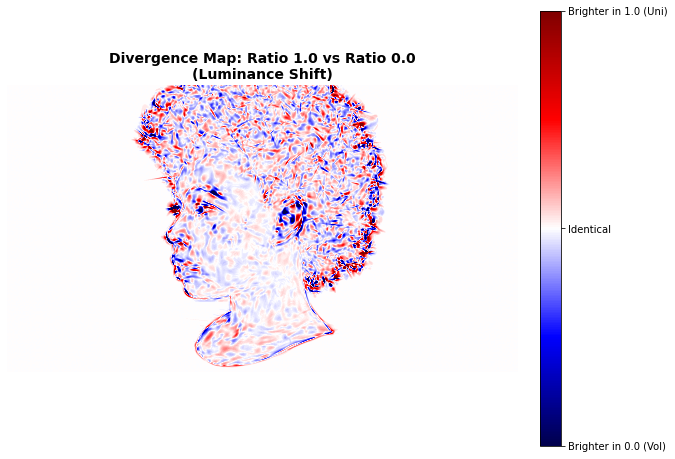

Máxima diferencia de intensidad encontrada: 0.5412


In [23]:
RATIO_A = 1.0  # Uniform, supposedly better skin, worse hair
RATIO_B = 0.0  # Volumetric, supposedly better hair, worse skin

# Escala de sensibilidad (0.1 significa +/- 10% de diferencia de brillo)
# Bájalo a 0.05 si las diferencias son muy sutiles.
V_LIMIT = 0.1 

if 'experiment_data' not in locals() or RATIO_A not in experiment_data or RATIO_B not in experiment_data:
    print(f"Error: Required ratios {RATIO_A} or {RATIO_B} not found in 'experiment_data'. Please run the batch rendering cell first.")
else:
    img_a = experiment_data[RATIO_A]['render'] # Ratio 1.0
    img_b = experiment_data[RATIO_B]['render'] # Ratio 0.0
    
    # Convert to greyscale (luminance)
    lum_a = to_luminance(img_a)
    lum_b = to_luminance(img_b)
    
    # Signed difference map
    diff_signed = lum_a - lum_b

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Usamos 'seismic' o 'bwr' (Blue-White-Red). 
    # El centro (0) es blanco.
    im = ax.imshow(diff_signed, cmap='seismic', vmin=-V_LIMIT, vmax=V_LIMIT)
    
    ax.set_title(f"Divergence Map: Ratio {RATIO_A} vs Ratio {RATIO_B}\n(Luminance Shift)", fontsize=14, fontweight='bold')
    ax.axis('off')
    
    # Colorbar explicativa
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_ticks([-V_LIMIT, 0, V_LIMIT])
    cbar.set_ticklabels([f'Brighter in {RATIO_B} (Vol)', 'Identical', f'Brighter in {RATIO_A} (Uni)'])
    
    plt.show()
    
    # Estadísticas rápidas
    max_diff = np.max(np.abs(diff_signed))
    print(f"Máxima diferencia de intensidad encontrada: {max_diff:.4f}")

#### Divergence Maps between GS and Frosting ratios

> Vanilla Baseline Ready.


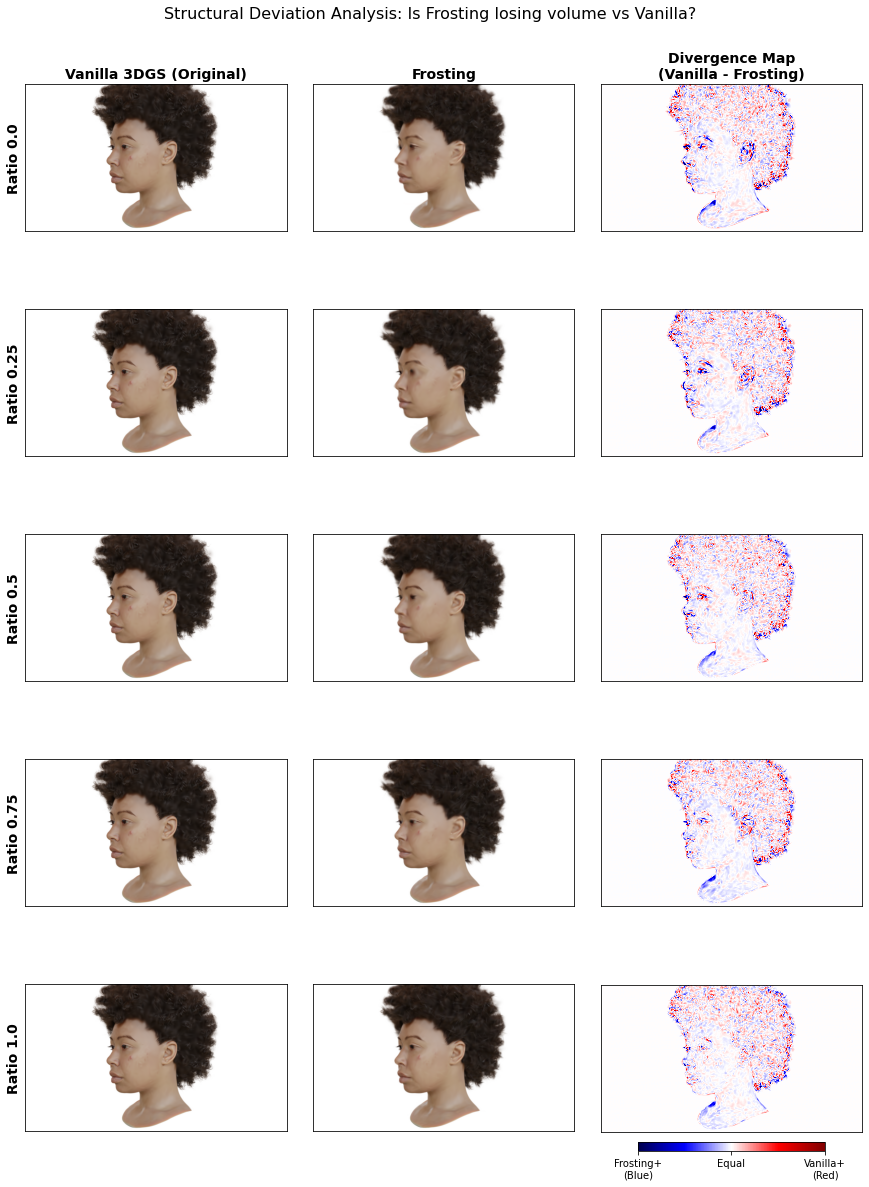

In [24]:
V_LIMIT = 0.15 

with torch.no_grad():
    vanilla_tensor = gs_model.render_image(camera_indices=CAM_IDX).clamp(0, 1)
    vanilla_np = vanilla_tensor.cpu().numpy()

if vanilla_np.shape[0] == 3:
    vanilla_np = vanilla_np.transpose(1, 2, 0)

vanilla_lum = to_luminance(vanilla_np)

print("> Vanilla Baseline Ready.")

if 'experiment_data' not in locals() or not experiment_data:
    print("[Error] 'experiment_data' dictionary is empty. Please run the 'Batch Processing' cell first.")
else:
    sorted_ratios = sorted(experiment_data.keys())
    n_rows = len(sorted_ratios)
    
    # [Vanilla | Frosting | Divergence]
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4 * n_rows))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    for i, ratio in enumerate(sorted_ratios):
        frosting_render = experiment_data[ratio]['render']
        frosting_lum = to_luminance(frosting_render)
        
        # Divergence
        # positive = Vanilla is brighter (Red)
        # negative = Frosting is brighter (Blue)
        diff_signed = vanilla_lum - frosting_lum
        
        ax_ref = axes[i, 0]
        ax_ref.imshow(vanilla_np)
        ax_ref.set_ylabel(f"Ratio {ratio}", fontsize=14, fontweight='bold')
        if i == 0: ax_ref.set_title("Vanilla 3DGS (Original)", fontsize=14, fontweight='bold')
        ax_ref.set_xticks([]); ax_ref.set_yticks([])

        ax_ren = axes[i, 1]
        ax_ren.imshow(frosting_render)
        if i == 0: ax_ren.set_title("Frosting", fontsize=14, fontweight='bold')
        ax_ren.set_xticks([]); ax_ren.set_yticks([])

        ax_div = axes[i, 2]
        # 'bwr' = Blue-White-Red
        # 'seismic'
        im = ax_div.imshow(diff_signed, cmap='seismic', vmin=-V_LIMIT, vmax=V_LIMIT)
        
        if i == 0: ax_div.set_title("Divergence Map\n(Vanilla - Frosting)", fontsize=14, fontweight='bold')
        ax_div.set_xticks([]); ax_div.set_yticks([])
        
        # Colorbar individual (o compartida al final)
        if i == n_rows - 1:
            cbar = fig.colorbar(im, ax=ax_div, orientation='horizontal', fraction=0.05, pad=0.05)
            # Etiquetas personalizadas para explicar los colores
            cbar.set_ticks([-V_LIMIT, 0, V_LIMIT])
            cbar.set_ticklabels(['Frosting+\n(Blue)', 'Equal', 'Vanilla+\n(Red)'])

    plt.suptitle(f"Structural Deviation Analysis: Is Frosting losing volume vs Vanilla?", fontsize=16, y=0.92)
    plt.show()

#### Original image vs Frosting ratios

In [ ]:
V_LIMIT = 0.15 

with torch.no_grad():
    vanilla_tensor = gs_model.render_image(camera_indices=CAM_IDX).clamp(0, 1)
    vanilla_np = vanilla_tensor.cpu().numpy()

if vanilla_np.shape[0] == 3:
    vanilla_np = vanilla_np.transpose(1, 2, 0)

vanilla_lum = vanilla_np.mean(axis=2)

print("> Vanilla Baseline Ready.")

if 'experiment_data' not in locals() or not experiment_data:
    print("[Error] 'experiment_data' dictionary is empty. Please run the 'Batch Processing' cell first.")
else:
    sorted_ratios = sorted(experiment_data.keys())
    n_rows = len(sorted_ratios)
    
    # [Vanilla | Frosting | Divergence]
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4 * n_rows))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    for i, ratio in enumerate(sorted_ratios):
        frosting_render = experiment_data[ratio]['render']
        frosting_lum = frosting_render.mean(axis=2)
        
        # Divergence
        # positive = Vanilla is brighter (Red)
        # negative = Frosting is brighter (Blue)
        diff_signed = vanilla_lum - frosting_lum
        
        ax_ref = axes[i, 0]
        ax_ref.imshow(vanilla_np)
        ax_ref.set_ylabel(f"Ratio {ratio}", fontsize=14, fontweight='bold')
        if i == 0: ax_ref.set_title("Vanilla 3DGS (Original)", fontsize=14, fontweight='bold')
        ax_ref.set_xticks([]); ax_ref.set_yticks([])

        ax_ren = axes[i, 1]
        ax_ren.imshow(frosting_render)
        if i == 0: ax_ren.set_title("Frosting", fontsize=14, fontweight='bold')
        ax_ren.set_xticks([]); ax_ren.set_yticks([])

        ax_div = axes[i, 2]
        # 'bwr' = Blue-White-Red
        # 'seismic'
        im = ax_div.imshow(diff_signed, cmap='seismic', vmin=-V_LIMIT, vmax=V_LIMIT)
        
        if i == 0: ax_div.set_title("Divergence Map\n(Vanilla - Frosting)", fontsize=14, fontweight='bold')
        ax_div.set_xticks([]); ax_div.set_yticks([])
        
        # Colorbar individual (o compartida al final)
        if i == n_rows - 1:
            cbar = fig.colorbar(im, ax=ax_div, orientation='horizontal', fraction=0.05, pad=0.05)
            # Etiquetas personalizadas para explicar los colores
            cbar.set_ticks([-V_LIMIT, 0, V_LIMIT])
            cbar.set_ticklabels(['Frosting+\n(Blue)', 'Equal', 'Vanilla+\n(Red)'])

    plt.suptitle(f"Structural Deviation Analysis: Is Frosting losing volume vs Vanilla?", fontsize=16, y=0.92)
    plt.show()

#### Divergence using PIL and GT vs Frosting

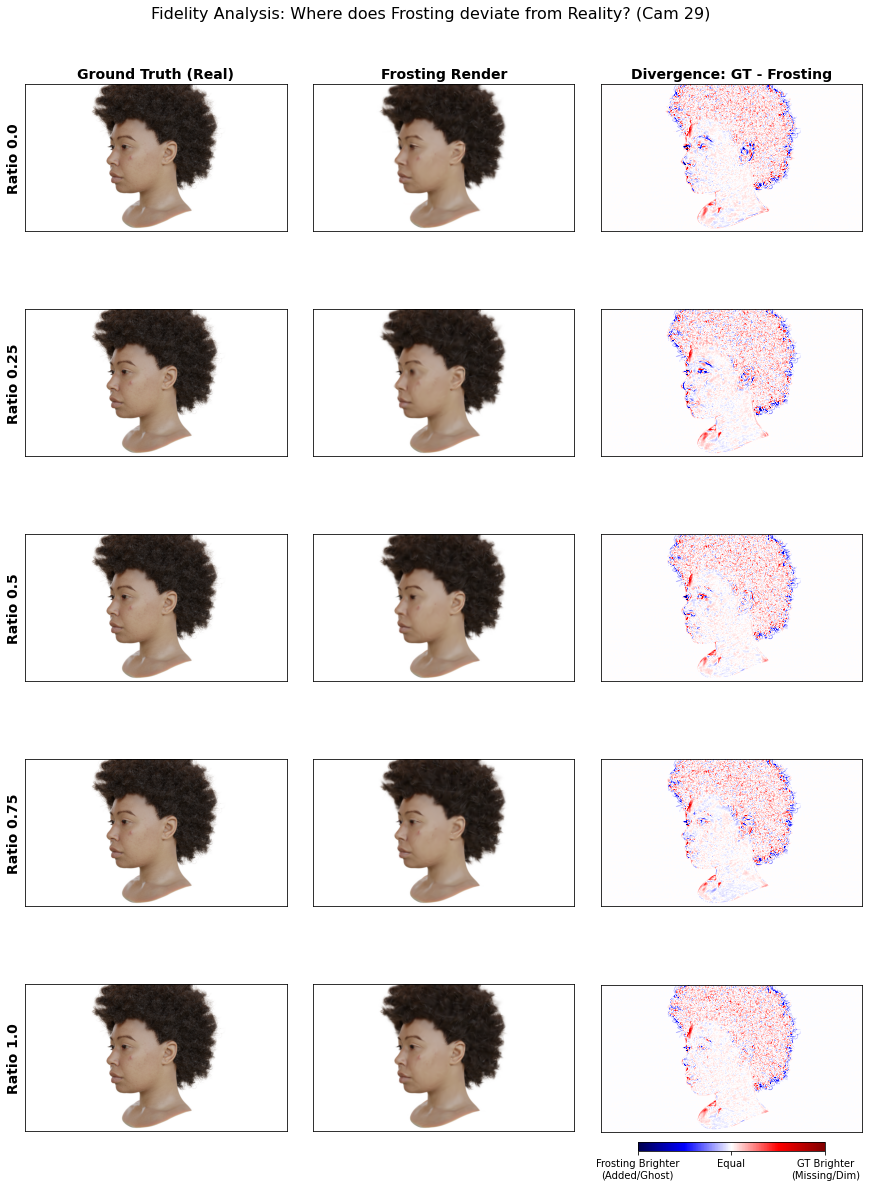

In [21]:
from PIL import Image
V_LIMIT = 0.2

def to_luminance(img_np):
    # Converts a numpy image [H,W,3] float [0,1] to luminance using PIL
    img_uint8 = (np.clip(img_np, 0, 1) * 255).astype(np.uint8)
    pil_img = Image.fromarray(img_uint8)
    pil_gray = pil_img.convert('L')
    
    # Return as normalized float array
    return np.array(pil_gray) / 255.0

# Load original GT image
with torch.no_grad():
    gt_tensor = gs_model.get_gt_image(camera_indices=CAM_IDX)
    gt_np = gt_tensor.cpu().numpy()

if gt_np.shape[0] == 3: gt_np = gt_np.transpose(1, 2, 0)

gt_lum = to_luminance(gt_np)    # Convert GT to luminance

if 'experiment_data' not in locals() or not experiment_data:
    print("[Error] 'experiment_data' dictionary is empty. Please run the 'Batch Processing' cell first.")
else:
    sorted_ratios = sorted(experiment_data.keys())
    n_rows = len(sorted_ratios)
    
    # [GT | Frosting | Divergence]
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4 * n_rows))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    for i, ratio in enumerate(sorted_ratios):
        frosting_render = experiment_data[ratio]['render']
        frosting_lum = to_luminance(frosting_render)

        # Positive (Red): GT is brighter -> Frosting lost detail/brightness
        # Negative (Blue): Frosting is brighter -> Frosting added noise/brightness
        diff_signed = gt_lum - frosting_lum

        ax_ref = axes[i, 0]
        ax_ref.imshow(gt_np)
        ax_ref.set_ylabel(f"Ratio {ratio}", fontsize=14, fontweight='bold')
        if i == 0: ax_ref.set_title("Ground Truth (Real)", fontsize=14, fontweight='bold')
        ax_ref.set_xticks([]); ax_ref.set_yticks([])

        ax_ren = axes[i, 1]
        ax_ren.imshow(frosting_render)
        if i == 0: ax_ren.set_title("Frosting Render", fontsize=14, fontweight='bold')
        ax_ren.set_xticks([]); ax_ren.set_yticks([])

        ax_div = axes[i, 2]
        im = ax_div.imshow(diff_signed, cmap='seismic', vmin=-V_LIMIT, vmax=V_LIMIT)
        
        if i == 0: ax_div.set_title("Divergence: GT - Frosting", fontsize=14, fontweight='bold')
        ax_div.set_xticks([]); ax_div.set_yticks([])
        
        # Colorbar
        if i == n_rows - 1:
            cbar = fig.colorbar(im, ax=ax_div, orientation='horizontal', fraction=0.05, pad=0.05)
            cbar.set_ticks([-V_LIMIT, 0, V_LIMIT])
            # Etiquetas explicativas
            cbar.set_ticklabels(['Frosting Brighter\n(Added/Ghost)', 'Equal', 'GT Brighter\n(Missing/Dim)'])

    plt.suptitle(f"Fidelity Analysis: Where does Frosting deviate from Reality? (Cam {CAM_IDX})", fontsize=16, y=0.92)
    plt.show()